In [109]:
# General packages
library(MASS)
library(latex2exp)
library(dplyr)
library(broom) 
library(gridExtra)
library(ggplot2)

# Spatial packages
library(sp)
library(reshape2)
library(geojsonio)
library(rgdal)
library(downloader)
library(maptools)
library(tmap)
library(stplanr)
library(leaflet)
library(sf)

# Load user modules
source("utils/data_processing.R")
source("utils/model_processing.R")

# Notebook configurations
options(warn=-1) # Turn on Warnings with warn=0
options(repr.plot.width=4, repr.plot.height=3)

# Introduction 
Following through [this excellent tutorial](https://rpubs.com/adam_dennett/257231) by Adam Dennett on geospatial flow modelling. The focus of this notebook is:
- Getting and cleaning data on commuter flows from StatsNZ
- Plotting the flow data onto the territorial authorities map for Wellington
- Findng the data equivalents used in the RPubs analysis for Wellington 
- Presenting and understanding the basic unconstrained model of spatial flows

# Spatial flow modelling: Theory


## Model 1
The simplest spatial flow model is the 'Gravity Model'. This model is essentially Newton's model of the gravitational force between two masses. The 'force' is proportional to the masses and to the inverse distance between the masses. A flow, $T_{ij}$ between two points $i$ and $j$ can be expressed as:

$$
T_{ij} = k\frac{P_i P_j}{D_{ij}}
$$

The variable $P$ captures the importance of $i$ and $j$. Like Newton's model of the gravitational force, the flow according to this model is equal in both directions. The flow from $i$ to $j$, $T_{ij}$, and $j$ to $i$, $T_{ji}$ are equal but opposite. This aspect doesn't quite represent reality. The flow of commuters is typically asymmetric - inflows do not equal outflows.  

## Model 2

The simple gravity model can be revised to handle asymmetric flows by splitting the single importance variable, $P$, into two: $V$ and $W$.  

$$
T_{ij} = k\frac{V_i W_j}{D_{ij}}
$$

Metrics that capture spatial importance broadly encompass supply side variables, $V$, like potential workforce numbers, and demand side variables, $W$, like work opportunities. 

Variable | Meaning | Use
--- | --- | ---
$V_{i}$ | Importance of origin | Origin commuting population 
$W_{j}$ | Importance of destination | Destination mean personal income
$T_{ij}$ | Distance between origin and destination | 'As the crow flies' distance
$k$ | Constance of proportionality | For scaling data - fitted parameter

## Model 3

Newton's original model has an inverse squared dependence on distance - which implies a highly local dependancy: very strong forces between close neightbours and negligible elsewhere. Smaller exponents on the inverse distance give non-negligible flows for mid to long range neighbours. The distance exponent is necessary for a commuting model since we don't expect commuters to be locally restricted.   

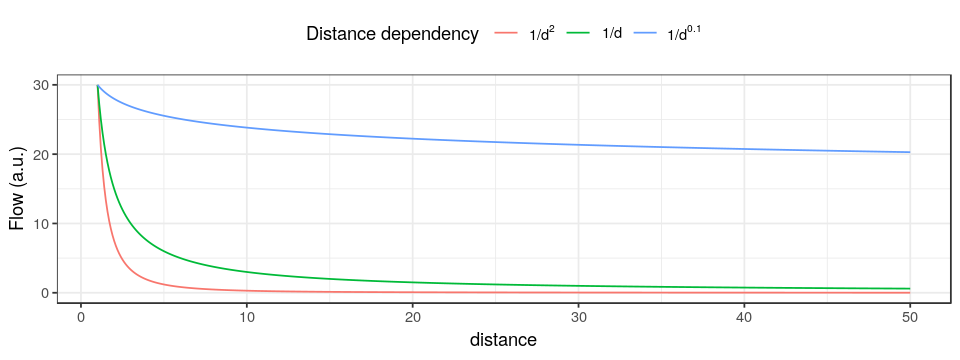

In [129]:
m1 <- 3
m2 <- 10
k <- 1

df <- data.frame(distance=seq(1, 50, 0.1)) %>% 
        mutate(gravity = (m1*m2*k) / (distance**2), 
               lin_inv = (m1*m2*k) / (distance), 
               small_inv = (m1*m2*k) / (distance**0.1)) %>% 
        melt(id='distance')

options(repr.plot.width=8, repr.plot.height=3)
ggplot(df) + 
    geom_line(aes(x = distance, y = value, colour=variable)) + 
    theme_bw() + 
    theme(legend.position="top") + 
    ylab("Flow (a.u.)") + 
    scale_colour_discrete(name  ="Distance dependency",
                          labels= unname(TeX(c("$1/d^{2}$", 
                                               "$1/d$", 
                                               "$1/d^{0.1}$"))))

A flexible distance exponent allows for tuning to the range of commutes. In reality, the distance captures the "transport friction". Mid to long range commutes would only be possible if the transport infrastructure enables them. The other two parameters, $V$ and $W$, can also be tuned with exponents to allow greater flexibility. The final version of the gravity model now looks like: 

$$
T_{ij} = k\frac{V^{\alpha}_i W^{\lambda}_j}{D^{\beta}_{ij}}
$$

The exponents can be interpreted as follows:

Parameter | meaning | explanation 
--- | --- | ---
$\alpha$ | emissivity | Average emission of origin workforce 
$\lambda$ | attraction | Average potential of destination to attract movement
$\beta$ | transport friction | Average "ease of commute" due to transport systems for the region

The 'average' in the exponents denotes a system average across all the flows. Ideally, we'd have a parameter for each region: how well it emits workers, how it captures workers and the ease of commute from it. 

## Fitting Model 3
Fitting the $\alpha$, $\beta$ and $\lambda$ from the original expression requires some complex non-linear model fitting. A simple workaround to the fitting complexity is to transform the equation to an additive expression that can be fit with linear regression. This is done by a consecutive natural log and exponentiation of the expression. 

$$
T_{ij} = k + \alpha \ln(V_i) + \lambda \ln(W_j) - \beta \ln(D_{ij})
$$

Since $T_{ij}$ is a count response variable, the regression expression is fit with a GLM and a Poisson log link function. 


## Visual summary

The key differences between the three models can be summarised as follows. 

Model | Summary | Key characteristic 
--- | --- | ---
1 | Simple gravity model | Single 'mass' like variable
2 | Asymmetric flow gravity model | Splits 'mass' into origin and destination characteristics 
3 | Tunable asymmetric flow | Modulation by propensity of workforce to leave origin; propensity of destination to capture moving workforce.  


![](assets/gravity-model-visual-summaries.png)

# Data
We require 4 key data sources for spatial flow modelling: 
- Geography shape file of the region
- Flow data
- Destination "attractiveness" features
- Origin "migration propensity" features

All 4 data sources have to be aggregated at the same spatial unit level. For this example, I've chosen to go with "statistical area 2" spatial unit. This is a mid-level coarse graining of the Wellington TA that loosely corresponds to suburbs. 

Data | Source 
--- | --- 
Geography shape file of the region | Stats NZ
Flow data | Stats NZ Commuter Flows visualisation
Destination "attractiveness" features | Mean personal income calculated from # people in income brackets
Origin "migration propensity" features | Total commuting population from each origin

Some notes: 
- Mean income is calculated from the coarse income brackets using the mid-bracket value. Because of the bracketing, it's only possible to calculate the mean, not the preferred median. I don't feel that this is a robust calculation since (1) the larger income brackets are much wider, and (2) the very high income bracket is not bounded - it's $150,000 and above.  
- Population value to use? As a simple approximating, we can use the number of commuting adults as the "population" - though it's the working, commuting, adult population of the area. 

## Getting flow data
Commuter flows from the NZ census are not available in a handy tabular format. But StatsNZ have provided a [Beta version of a commuter flow interactive map](https://www.stats.govt.nz/tools/commuter-view). I manually downloaded the flow data for each of the statistical areas within the Wellington City Territorial Authority (TA). The data is limited because the Wellington City TA doesn't capture the Hutt Valley or Porirua - two key suburban areas (with many commuters) of the Greater Wellington region. These additional ares will be extracted for the complete analysis. 

In [2]:
# Read commuter flow data
df_flow <- readCommuterFlows("data/commuter_flow_wellington_city.csv")

In [47]:
# Minor cleaning 
df_flow_clean <- df_flow %>% filter(to_name %in% from_name) %>% filter(flow_type == 'out')
df_flow_clean %>% head(2)

to_code,to_name,flow_type,year_2006,year_2013,from_code,from_name
575300,Kelburn,out,9,9,576500,Adelaide
576901,Kilbirnie East,out,9,6,576500,Adelaide


## Get origin and destination features
The [destination feature was also obtained from the 2013 Census](http://nzdotstat.stats.govt.nz/wbos/Index.aspx?DataSetCode=TABLECODE8110&_ga=2.232663639.992521087.1536550217-1310899028.1534717910). I included all the income brackets, and all the statistical units part of Wellington City TA under the 'Area' filter. Some manual cleaning was required when converting the XLS file to CSV. 

In [49]:
# Get destination importance features: personal income
income_df <- read.csv("data//wellington-city-ta-personal-income-bracket.csv", sep=';', strip.white=T)
income_df <- tibble::rownames_to_column(income_df)

For various reasons I'm not privy to, the personal income is split into income brackets. This likely represents the way the question of personal income was asked in the Census itself. The brackets in the 2013 survey are: 

In [45]:
print(colnames(income_vals)[1:length(colnames(income_vals)) - 1])

 [1] "Zero.income"        "X.1..5.000"         "X.5.001..10.000"   
 [4] "X.10.001..15.000"   "X.15.001..20.000"   "X.20.001..25.000"  
 [7] "X.25.001..30.000"   "X.30.001..35.000"   "X.35.001..40.000"  
[10] "X.40.001..50.000"   "X.50.001..60.000"   "X.60.001..70.000"  
[13] "X.70.001..100.000"  "X.100.001..150.000" "X.150.001.or.more" 


We can clean up this data and calculate a mean income value. The value is not a robust calculation since it's affected by statistical area units sample sizes and poor resolution from larger income brackets. But it's the best approximation I can see. In a [later section](#Towards-a-better-model), I discuss how we can get a better representation of the destination attraction. 

In [48]:
# Data cleaning and shaping to a single numeric value of income per statistical area
income_vals <- cleanIncomeData(income_df)
df_mean_income <- calculateMeanIncome(income_vals, df_flow_clean)

Using statistical_area as id variables
Joining, by = "statistical_area"


I've used the total number commuters as the origin feature set. Ideally, I'd use the working population for the area but I was a little tired of dealing with the clunky and hard to understand Stats NZ Census interface.  

In [26]:
# Generate an approximate origin feature from flow data
df_commuter_popn <- df_flow %>% 
                    filter(to_name %in% from_name) %>%
                    filter(flow_type == "out") %>%
                    group_by(from_name) %>%
                    summarise(commuting_popn = sum(year_2013))

## Get Statistical Area Unit boundaries
In the next iteration of this analysis, I'll go through the awkward issues with the Stats NZ geographic boundaries, but for now it suffices to say that we can get [boundary files for Wellington City TA](http://www3.stats.govt.nz/digitalboundaries/census/Wellington_L2_2006_NZMG_ArcShp.zip?_ga=2.203187161.992521087.1536550217-1310899028.1534717910). A subset of the folder specifies the Area Unit boundaries and I've uploaded this to Github. 

In [27]:
wgtn <- readOGR("./data/wgtn-stat-area-2", layer="AU_TA_Wellington_CC")
wgtn

OGR data source with driver: ESRI Shapefile 
Source: "/home/shrividya/Documents/wellington-commutes/data/wgtn-stat-area-2", layer: "AU_TA_Wellington_CC"
with 68 features
It has 5 fields


class       : SpatialPolygonsDataFrame 
features    : 68 
extent      : 2645098, 2669062, 5981296, 6005477  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=nzmg +lat_0=-41 +lon_0=173 +x_0=2510000 +y_0=6023150 +datum=nzgd49 +units=m +no_defs +ellps=intl +towgs84=59.47,-5.04,187.44,0.47,-0.1,1.024,-4.5993 
variables   : 5
names       :  UID_AU_TA,  AU_NO, TA_NO,      AU_NAME,         TA_NAME 
min values  : 572500|047, 572500,   047,     Adelaide, Wellington City 
max values  : 577700|047, 577700,   047, Wilton-Otari, Wellington City 

# Data Processing
Some processing is required to get the final dataset for the model: 
- Generating the pairwise distance matrix
- Re-labelling the distance matrix to human-readable area names and codes
- Adding the destination and origi features

## Calculate pairwise distances

In [28]:
# Calculate and tabulate pairwise distances
nz_grid = "+init=epsg:2193"
wgtn_grid <- spTransform(wgtn, nz_grid)
df_distance <- melt(spDists(wgtn_grid))

## Geo-munging

In [29]:
# Create the lookup dataframes to match with the pairwise distance dataframe
# Names dataframe: numeric sequence --> Name
names <- as.data.frame(as.character(wgtn$AU_NAME))
names$num <- seq(1, nrow(names))
colnames(names) <- c('name', 'num')

# Code dataframe: Name --> GeoCode
code_df <- data.frame(wgtn$UID_AU_TA, wgtn$AU_NAME)
colnames(code_df) <- c('UID_AU_TA', 'geo_code')

In [30]:
df_distance_clean <- labelledPairwiseDistance(df_distance, code_df, names)
df_model <- dataForFlowModel(df_distance_clean, df_flow_clean, df_commuter_popn, df_mean_income)

## Plotting some flows
Once we have the final dataset, we can plot a small subset of commuter flows with the *stplanr* packages. Note, to get this working, the first two columns of the dataset have to be the Geocode that is used in the boundary files. 

In [31]:
#use the od2line function from stplanr
df_model_sub <- df_model %>% select(Orig_Code, Dest_Code, year_2013) %>% sample_n(20)
travel_network <- od2line(flow = df_model_sub,  zones = wgtn)
travel_networkwgs <- spTransform(travel_network, nz_grid)

#and set the line widths to some sensible value according to the flow
w <- df_model_sub$year_2013 / max(df_model_sub$year_2013) * 10

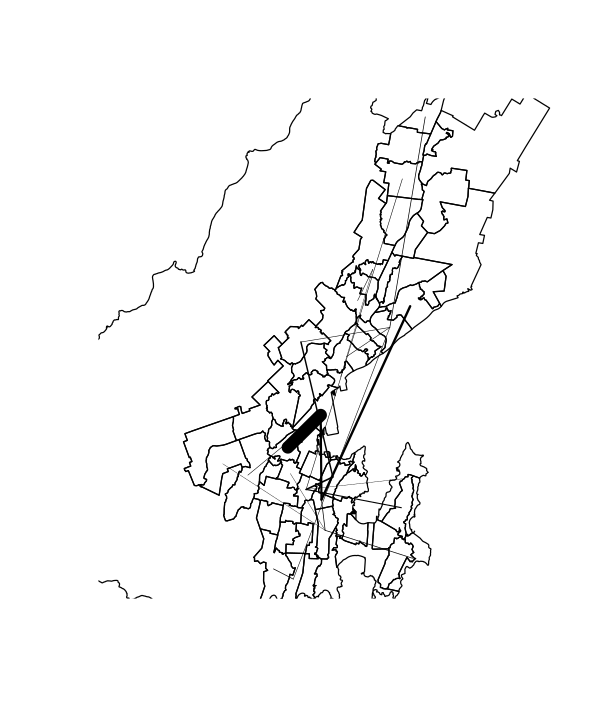

In [32]:
options(repr.plot.width=5, repr.plot.height=6)
plot(travel_networkwgs, lwd = w)
plot(wgtn_grid, add=T)

# Spatial flow modelling: Practice
After a lot of hand-wringing, munging and strife; we're finally at the modelling stage!  


## Relationships between model variables
The gravity model we're fitting assumes some relationships between the variables and the response:
- Linear or positive relationship between flow and workforce population at origin
- Linear or positive relationship between flow and workforce capture at destination
- Negative relationship between flow and distance

The plots below show a lot of noise from the expected trends - the destination feature even has the opposite to expected. This unconventional wisdom is that commuter flows are highest to low income areas! Nonetheless, we can still persevere and see if the model can fit any of the flows at all.   


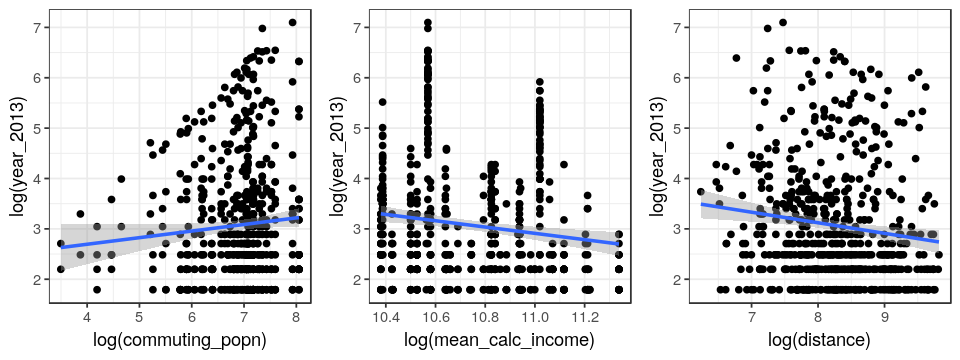

In [122]:
options(repr.plot.width=8, repr.plot.height=3)

plot1 <- qplot(log(commuting_popn), log(year_2013), data=df_model) + geom_smooth(method = lm) + theme_bw()
plot2 <- qplot(log(mean_calc_income), log(year_2013),data=df_model) + geom_smooth(method = lm) + theme_bw()
plot3 <- qplot(log(distance), log(year_2013), data=df_model) + geom_smooth(method = lm) + theme_bw()

grid.arrange(plot1, plot2, plot3, ncol=3)

## Poisson GLM

In [34]:
#run the unconstrained model
uncosim <- glm(year_2013 ~ log(commuting_popn) + log(mean_calc_income) + log(distance), 
               na.action = na.exclude, family = poisson(link = "log"), data = df_model)

# Add fit to df 
df_model$fitted <- fitted(uncosim)
summary(uncosim)


Call:
glm(formula = year_2013 ~ log(commuting_popn) + log(mean_calc_income) + 
    log(distance), family = poisson(link = "log"), data = df_model, 
    na.action = na.exclude)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-13.520   -7.889   -5.739   -2.705   57.993  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           13.267027   0.240052   55.27   <2e-16 ***
log(commuting_popn)    0.476339   0.009074   52.50   <2e-16 ***
log(mean_calc_income) -1.008664   0.020937  -48.18   <2e-16 ***
log(distance)         -0.210736   0.007455  -28.27   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 75317  on 597  degrees of freedom
Residual deviance: 69426  on 594  degrees of freedom
AIC: 72377

Number of Fisher Scoring iterations: 6


The GLM has fitted the exponents with a high degree of signficance. A subset of the fitted and original values of flow show that the model doesn't predict well at all. The fraction of explained variance is less than 5%. In colloquial terms, we'd say 'this model sucks'. 

In [42]:
df_model %>% filter(to == 'Lambton') %>% select(from, to, mean_calc_income, year_2013, fitted) %>% head(5)

from,to,mean_calc_income,year_2013,fitted
Johnsonville East,Lambton,38917.37,132,31.96957
Newlands North,Lambton,38917.37,312,51.27917
Grenada Village,Lambton,38917.37,168,34.81375
Mt Victoria West,Lambton,38917.37,1209,122.48224
Johnsonville North,Lambton,38917.37,234,42.82457


In [36]:
CalcRSquared(df_model$year_2013, df_model$fitted)

[1] 0.03963358

# Towards a better model

- The model we've implemented is terrible - it captures none of the variance. That's because:
    - The destination importance feature is hopeless.
    - There is a large asymmetry in destination importance that the features need to capture.
    
The poor predictive power of the model is also due to the fact that Wellington doesn't have a strong distance dependence. So, the attractiveness of the CBD really trumps the distance variable. Therefore it is imperative that we model CBD attractiveness appropriately.    

The asymmetry in attractiveness exists most of the offices exist in the downtown part of Wellington. Weekly commutes are thus mostly captured by inflows from all over the Wellington region to a relatively small part of the inner city. One way to possibly capture this as a feature is by aggregating the number of commercial type buildings within a given statistical area. We can get the commercial building data with [this Overpass query](http://overpass-turbo.eu/s/BHN). 

# Technical Details 
## Data Issues

In [40]:
names_income_df <- as.character(df_mean_income$statistical_area)
names_map <- as.character(wgtn$AU_NAME)

in_census <- setdiff(names_income_df, names_map)
in_map <- setdiff(names_map, names_income_df)

## Package installation
I'm working from a Ubuntu 18.04 VM on Windows. I needed to install a bunch of additional linux packages for the necessary R libraries and their dependencies:
- sudo apt  install protobuf-compiler
- sudo apt install libprotobuf-dev
- sudo apt install libv8-3.14-dev
- sudo apt-get install libjq-dev
- sudo apt install libudunits2-dev
- sudo apt install libgdal-dev
- sudo apt install libgdal1-dev (though I'm not 100% sure of this one)
